# Flatiron Phase 4 Project

## Aaron Galbraith

### Submitted: October 10, 2023

## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

# Business Understanding

Apple launched the iPad 2 on March 11, 2011, the same day that the 2011 SXSW Festival began in Austin, TX. Apple also launched a pop-up store in Austin specifically to sell these and other products to the swell of crowds who attended the festival that year.\* Apple product launches for their lines of iPods, iPhones, and iPads were a very big deal at the time, and much media coverage was devoted to the frenzy that accompanied each launch, e.g. Apple customers eagerly waiting in long lines for the newest product on the first day it was available for sale.

Apple can simply look to its accounting to see how successful its sales were in Austin during SXSW. But there is more to be learned than just how many dollars it made in the short term. By heavily promoting its product launches in an environment such as this festival, Apple encourages its customers (and loyal fans, and potential customers, and even detractors) to join in a conversation about them. This creates a great opportunity for Apple to get candid feedback on a massive scale about what it's doing that excites people as well as what disappoints people. This feedback can obviously inform future choices Apple makes in developing and launching its products.

Following the festival, Apple wished to gain insight into how its presence at the festival had been received. Tweets with the hashtag #sxsw were collected and labeled according to 1) what sentiment if any they expressed and 2) which if any tech brands or products (limited to Apple and Google) were mentioned. Apple wanted to know what it could learn not only from its own festival presence but also from Google's presence at the same festival.

<sub><sup>\*Essentially none of this information accompanied the dataset. Every single tweet contained the hashtag #sxsw, and a frequency analysis of the tweets indicated they took place in 2011. Further research yielded websites such as https://techcrunch.com/2011/03/10/ipad-2-sxsw/ and https://googleblog.blogspot.com/2011/03/google-at-sxsw-2011-austin-here-we-come.html, which provided helpful details about the activities of Apple and Google at the 2011 SXSW Festival.</sup></sub>

# Data Understanding

## Import files

Here we'll import all the tools we'll need (and quite a few more that we won't need).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from unidecode import unidecode

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import TweetTokenizer

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import imblearn.pipeline
from operator import itemgetter
import string
from wordcloud import WordCloud

SEED = 19

do_grids = False

## Load and briefly explore data set

In [2]:
# read csv into dataframe
df = pd.read_csv('../data/tweets.csv', encoding='latin-1')
# show overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# show row and column counts
df.shape

(9093, 3)

In [4]:
# show how many unique values for each feature
df.nunique()

tweet_text                                            9065
emotion_in_tweet_is_directed_at                          9
is_there_an_emotion_directed_at_a_brand_or_product       4
dtype: int64

From the above we see that there are evidently some duplicated tweets; there are 4 different "emotion" labels; and there are 9 different product or brand labels.

In [5]:
# show value counts for one feature
df.emotion_in_tweet_is_directed_at.value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

Apple products seem to be mentioned more than Google products.

In [6]:
# show normalized value counts for one feature
round(df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.59
Positive emotion                      0.33
Negative emotion                      0.06
I can't tell                          0.02
Name: proportion, dtype: float64

There are very few negative emotions expressed. The majority are neutral

In [7]:
# show breakdown of sentiment labels for tweets that have no product or brand identified
round(df[df.emotion_in_tweet_is_directed_at.isna()] \
.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.91
Positive emotion                      0.05
I can't tell                          0.03
Negative emotion                      0.01
Name: proportion, dtype: float64

For tweets not associated with a brand, most are labeled neutral, but a few are not.

In [8]:
# show examples of tweets that DO express emotion but are NOT directed at a specific product
df[(df.is_there_an_emotion_directed_at_a_brand_or_product != 'No emotion toward brand or product') &
   (df.emotion_in_tweet_is_directed_at.isna())
  ].tweet_text

46      Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...
64      Again? RT @mention Line at the Apple store is ...
68      Boooo! RT @mention Flipboard is developing an ...
90      Thanks to @mention for publishing the news of ...
102     ÛÏ@mention &quot;Apple has opened a pop-up st...
                              ...                        
9043    Hey is anyone doing #sxsw signing up for the g...
9049    @mention you can buy my used iPad and I'll pic...
9052    @mention You could buy a new iPad 2 tmrw at th...
9054    Guys, if you ever plan on attending #SXSW, you...
9058    &quot;Do you know what Apple is really good at...
Name: tweet_text, Length: 504, dtype: object

Clearly some/most of the tweets we can see here *are* associated with brands.

## Summary of data

There are 9,093 records and 3 features. As there are only 9,065 unique tweets, it appears that there are some duplicates.

A little more than one third (3,291) of the tweets are identified as being directed at a particular product or brand associated with either Google or Apple, while the majority do not identify a product or brand.

Relatively few records have been identified as having a negative or "I can't tell" emotion.

For the 5,802 records that don't identify a product or brand, about 9% of them were identified as having something other than "no emotion". Upon investigation of these, it appears that some of them mention "Apple" or "iPad" after all, so evidently some tweets have not been successfully associated with a product or brand.

# Data Preparation

## Renaming features

The column names are a bit cumbersome, so we'll give them new names that are easier to deal with.

In [9]:
# rename columns
df.rename(columns={'tweet_text': 'text',
                   'emotion_in_tweet_is_directed_at': 'brand',
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'},
          inplace = True)

## Missing values

In [10]:
# show records with missing text
df[df.text.isna()]

,text,brand,sentiment
6,NaN,NaN,No emotion toward brand or product


We can't do anything with a record whose text is missing, so we'll drop it.

In [11]:
# drop records with missing text values
df.dropna(subset=['text'], inplace=True)

## Edit values

As these tasks may increase the number of duplicate records, we should perform them before we look for those duplicates.

### Lower case

It's not likely that we'll lose anything important by shifting all the text to lower case, especially given the nature of tweeting.

In [12]:
# shift all text to lower case
df['text'] = df['text'].str.lower()

### Rename and merge sentiments

The sentiment labels could be more succinct. We'll change them.

Also, since there were so few "unknown" sentiments, we'll just group those together with "neutral" sentiments.

In [13]:
sentiment_rename = {
    "No emotion toward brand or product": "neutral",
    "Positive emotion": "positive",
    "Negative emotion": "negative",
    "I can't tell": "neutral"
}

df.sentiment = df.sentiment.apply(lambda x: sentiment_rename[x])

### Merge brand labels

In [14]:
# show breakdown of brand before merging
df.brand.value_counts()

brand
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [15]:
# assign either apple or google label and fill in missing values with other
df['brand'].replace(['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'apple',
                     inplace=True)
df['brand'].replace(['Google', 'Other Google product or service', 'Android App', 'Android'], 'google',
                     inplace=True)
df['brand'].fillna('other',
                    inplace=True)

In [16]:
# show breakdown of brand after merging
df.brand.value_counts()

brand
other     5801
apple     2409
google     882
Name: count, dtype: int64

## Detect missing brand labels

As noted earlier, we suspect many of the tweets labeled "other" actually refer to a certain product or brand. We'll use some helpful keywords to reclassify some of the tweets that are not yet associated with either brand.

In the event that some tweets happen to mention both brands, we'll make a label for "both", and we'll label everything else "neither".

In [17]:
# make key word lists for apple and google
apple_words = ['ipad', 'apple', 'iphone', 'itunes', 'ipad2']
google_words = ['google', 'android', 'blogger', 'marissa', 'mayer', 'sketchup', 'h4ckers', 'youtube', 'circles']
# add hashtags
apple_hash = []
for word in apple_words:
    apple_hash.append('#'+word)
apple_words.extend(apple_hash)
google_hash = []
for word in google_words:
    google_hash.append('#'+word)
google_words.extend(google_hash)
# consolidate all terms in one list
brand_words = apple_words + google_words

In [18]:
# make a function that relabels brand values by finding what keywords are mentioned in the text
def brand_fix(text, brand):
    # only relabel records that do not have one of the two brands already associated
    if brand != 'other':
        return brand
    else:
        apple, google = False, False
        # look for apple keyword
        for word in apple_words:
            if word in text:
                apple = True
                break
        # look for google keyword
        for word in google_words:
            if word in text:
                google = True
                break

        # return correct new label
        if apple & ~google:
            return 'apple'
        elif google & ~apple:
            return 'google'
        elif apple & google:
            return 'both'
        else:
            return 'neither'

In [19]:
# run above function to relabel brand values
df['brand'] = df.apply(lambda x: brand_fix(x.text, x.brand), axis=1)
# show breakdown of brand after running function
df.brand.value_counts()

brand
apple      5394
google     2845
neither     663
both        190
Name: count, dtype: int64

In [20]:
df[df.brand == 'apple'].sentiment.value_counts(normalize=True)

sentiment
neutral     0.527994
positive    0.394883
negative    0.077123
Name: proportion, dtype: float64

In [21]:
df[df.brand == 'google'].sentiment.value_counts(normalize=True)

sentiment
neutral     0.655185
positive    0.291740
negative    0.053076
Name: proportion, dtype: float64

We were able to label a vast majority of the unassociated tweets with a brand that the tweet mentions.

## Duplicates

Now we'll address duplicated tweets

In [22]:
# show how many records are duplicates
df.duplicated().value_counts()

False    9050
True       42
Name: count, dtype: int64

Let's see if there is a difference if we only select for duplicated text (not product or sentiment).

In [23]:
# show how many records are duplicates for the text value only
df.duplicated(subset=['text']).value_counts()

False    9047
True       45
Name: count, dtype: int64

It looks like 3 text records are duplicated with either different sentiments or different associated brands. Let's look at what sentiment labels these were given, as separate groups.

In [24]:
# show sentiment identification for groups of duplicated tweets
for i, index in enumerate(df.drop_duplicates()[df.duplicated(subset=['text'])].index):
    print(
        'duplicate group', i+1, '\n',
        df.loc[index].text, '\n\n',
        df[df.text == df.loc[index].text].sentiment.value_counts(),
        '\n\n- - - -\n'
    )

duplicate group 1 
 win free ipad 2 from webdoc.com #sxsw rt 

 sentiment
neutral     4
positive    2
Name: count, dtype: int64 

- - - -

duplicate group 2 
 rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw 

 sentiment
neutral     5
positive    4
Name: count, dtype: int64 

- - - -

duplicate group 3 
 rt @mention rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link} 

 sentiment
neutral     2
positive    1
Name: count, dtype: int64 

- - - -



<ipython-input-24-7c19d15d088f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i, index in enumerate(df.drop_duplicates()[df.duplicated(subset=['text'])].index):


In [25]:
# show some of the duplicated tweets
df[df.duplicated()].text.head(25)

467        before it even begins, apple wins #sxsw {link}
468        before it even begins, apple wins #sxsw {link}
664     if you're in a room full of people w/good wi-f...
775     google to launch major new social network call...
776     google to launch major new social network call...
798     google to launch major new social network call...
2231    marissa mayer: google will connect the digital...
2232    marissa mayer: google will connect the digital...
2559    counting down the days to #sxsw plus strong ca...
3810             win free ipad 2 from webdoc.com #sxsw rt
3811             win free ipad 2 from webdoc.com #sxsw rt
3812             win free ipad 2 from webdoc.com #sxsw rt
3814             win free ipad 2 from webdoc.com #sxsw rt
3950    really enjoying the changes in gowalla 3.0 for...
3962    #sxsw is just starting, #ctia is around the co...
4897    oh. my. god. the #sxsw app for ipad is pure, u...
4954               40% of google maps use is mobile #sxsw
5338    rt @me

It's a tough call what to do with these duplicates. Some of them, like the first one, could be multiple people sharing the same article, and it could be meaningful to count all such instances, as they represent *more* of that sentiment. Some others, however, like the "win free ipad 2", appear to be from a business promoting itself. In that case, we wouldn't want to skew our results by counting all such instances.

In any event, due to the nature of tweeting, it is certainly plausible that these duplicated tweets were not erroneously duplicated, but rather they were actually separate, if identical, tweets when they were posted.

Several duplicates we see here start with "rt". We know that "rt" means "retweet", which specifically is a way for Twitter users to amplify a tweet they agree with.

Let's compromise on the duplicates by keeping all retweets but dropping the other duplicates.

In [26]:
# combine ALL retweets with NON-DUPLICATED other tweets
df = pd.concat([
    # retweets
    df[df.text.str.startswith('rt')],
    # non-retweets, minus duplicates
    df[~df.text.str.startswith('rt')].drop_duplicates()
# reset the index
]).reset_index()
# drop newly created index column
df.drop(columns='index', inplace=True)

In [27]:
# show row and column counts
df.shape

(9071, 3)

## Begin NLP

Now that we have the data set we want to work with, we'll use natural language processing techniques to help us analyze it.

First we'll create a list of all the tweets. As we tokenize and lemmatize, etc, we can always come back to this for the full context.

In [28]:
# make list of all tweet texts
tweets = df.text.to_list()

Then we'll create a list of all the tokens. To do this, we'll use a tokenizer that is specifically designed to parse tweets from Twitter and a lemmatizer.

In [29]:
# make tokenizer
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True
)

# create list of tokens from data set
tokens = tokenizer.tokenize(','.join(tweets))

# remove hashtags and accents
tokens = [unidecode(word) for word in tokens if not word.startswith('#')] + \
[unidecode(word[1:]) for word in tokens if word.startswith('#')]

We'll take this opportunity while lemmatizing to get rid of hashtags.

In [30]:
# make lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatize the list of words
tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

Let's look at the most frequently occurring tokens.

In [31]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized).most_common(25)

[(',', 12561),
 ('sxsw', 9573),
 ('.', 5890),
 ('the', 4423),
 ('link', 4314),
 ('}', 4288),
 ('{', 4285),
 ('to', 3580),
 ('at', 3097),
 ('rt', 2952),
 ('ipad', 2670),
 ('a', 2567),
 ('for', 2544),
 ('google', 2451),
 ('!', 2368),
 ('apple', 2223),
 ('in', 1936),
 (':', 1830),
 ('of', 1711),
 ('is', 1705),
 ('"', 1696),
 ('and', 1635),
 ('?', 1611),
 ('iphone', 1573),
 ('store', 1518)]

This list is utterly dominated by stopwords. In addition to punctuation characters, some twitter-specific terms appear here, as well as some ordinary stopwords, and of course sxsw. Let's start a stopwords list and put it to use.

In [32]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = stopwords.words('english')
# add to this list some twitter-specific terms
stop_list.extend(['sxsw', 'link', 'rt'])
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend(['', 'ha', 'wa'])

In [33]:
# make stopped list of tokens
tokens_stopped = [word for word in tokens_lemmatized if word not in stop_list]

In [34]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped).most_common(25)

[('ipad', 2670),
 ('google', 2451),
 ('apple', 2223),
 ('iphone', 1573),
 ('store', 1518),
 ('2', 1370),
 ('new', 1087),
 ('austin', 956),
 ('app', 819),
 ('launch', 688),
 ('circle', 685),
 ('social', 644),
 ('...', 639),
 ('android', 588),
 ('today', 571),
 ('network', 471),
 ('get', 453),
 ('line', 442),
 ('via', 435),
 ('u', 434),
 ('pop-up', 422),
 ('party', 401),
 ('free', 383),
 ('called', 358),
 ('mobile', 343)]

This looks much better.

It seems quite probable that the "2" here is often occurring when tweets include a space in the expression "ipad 2". Let's look at them in context to see if we're right.

First we'll write a function to pull some random tweets that feature a given term or phrase.

In [35]:
# a function that displays several randomly chosen tweets that include a given term or phrase
def tweet_samples(term, count=5):
    relevant_tweets = [tweet for tweet in tweets if term in tweet]
    if len(relevant_tweets) > 0:
        count = min(count, len(relevant_tweets))
        random_tweets = np.random.choice(relevant_tweets, count)
        for tweet in random_tweets:
            print(tweet)
    else:
        print('No tweets contain this phrase.')

In [36]:
tweet_samples('2', count=5)

rt @mention tim o'reilly web 2.0 definition -companies that survived built value from consumer-generated data. ebay, amazon, google #sxsw
rt @mention i'll use an ipad 2 if someone gives it to me. otherwise, iphone is actually more than up to task #sxsw
#technews apple heads to sxsw, sets up temporary store in austin {link} #tech_news #apple #ipad_2 #rance_wilemon #sxsw #tech
ok visiting that! @mention apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link}
our updated iphone app has song info for select streams (incl. @mention 24/7) &amp; live video streaming in time for #sxsw {link}


Indeed, it looks like a lot of those 2s are really part of iPad 2.

Let's write a quick function to join those words together in future lemmatization.

In [37]:
def ipad_fix(word_list):
    new_word_list = []
    for i in range(len(word_list)):
        if i < len(word_list) - 1 and word_list[i] == 'ipad' and word_list[i+1] == '2':
            new_word_list.append('ipad2')
        elif i > 0 and word_list[i-1] == 'ipad' and word_list[i] == '2':
            continue
        else:
            new_word_list.append(word_list[i])
    return new_word_list

In [38]:
tokens_stopped = ipad_fix(tokens_stopped)

In [39]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped).most_common(25)

[('google', 2451),
 ('apple', 2223),
 ('iphone', 1573),
 ('ipad', 1541),
 ('store', 1518),
 ('ipad2', 1423),
 ('new', 1087),
 ('austin', 956),
 ('app', 819),
 ('launch', 688),
 ('circle', 685),
 ('social', 644),
 ('...', 639),
 ('android', 588),
 ('today', 571),
 ('network', 471),
 ('get', 453),
 ('line', 442),
 ('via', 435),
 ('u', 434),
 ('pop-up', 422),
 ('party', 401),
 ('free', 383),
 ('called', 358),
 ('mobile', 343)]

By the way, we can use term frequency to try to figure out what year all of this took place. We'll start around the year the first iPhone was released (2007) and include the year the dataset was created (2013).

In [40]:
# iterate over a likely timespan
for year in range(2007,2014):
    # show how frequently a given year was mentioned
    print(str(year)+':', FreqDist(tokens_stopped)[str(year)])

2007: 0
2008: 0
2009: 1
2010: 4
2011: 75
2012: 0
2013: 0


This is how we deduced that the data comes from 2011 (which allowed us to learn more context for the SXSW conference in Austin, TX from that particular year).

# Exploration

## Overview

Let's compare the brand and sentiment distributions of the tweets.

/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


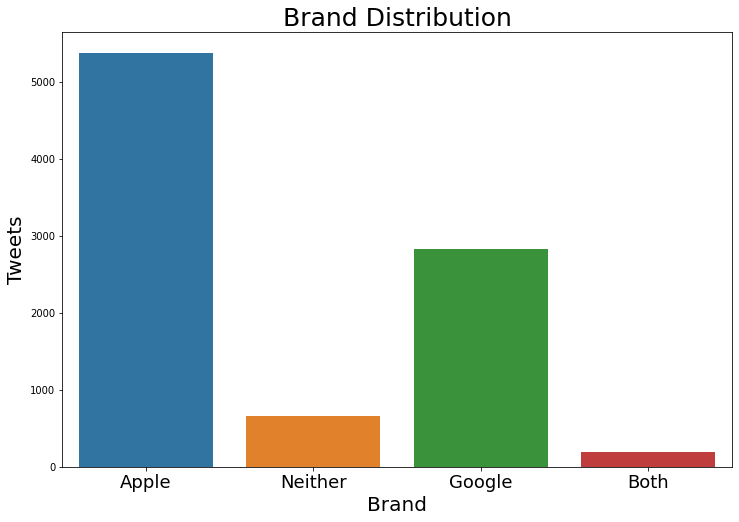

In [41]:
labels = ['Apple','Neither','Google', 'Both']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(df['brand'])
plt.title('Brand Distribution', fontsize=25)
# ax.set_yticklabels([0,500,1000,1500,2000,2500,3000,3500], fontsize=18)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('Brand',fontsize=20)
plt.ylabel('Tweets',fontsize=20)
# plt.legend(loc=1, prop={'size': 15})
plt.show()

We've associated the vast majority of the tweets with Apple or Google (or both).

/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


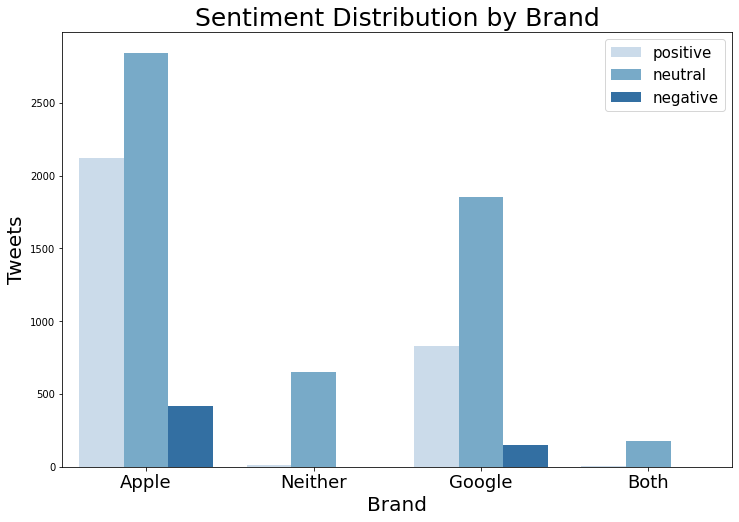

In [42]:
labels = ['Apple','Neither','Google', 'Both']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(df['brand'], hue=df['sentiment'], palette='Blues')
plt.title('Sentiment Distribution by Brand', fontsize=25)
# ax.set_yticklabels([0,500,1000,1500,2000,2500], fontsize=18)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('Brand',fontsize=20)
plt.ylabel('Tweets',fontsize=20)
plt.legend(loc=1, prop={'size': 15})
plt.show()

Tweets that mentioned both or neither brand almost exclusively lacked an identifiable sentiment. These will only factor into some parts of our analysis.

Apple and Google had a similar distribution of positive, neutral and negative tweets. This will create some class imbalance issues during modeling.

## Word clouds

We'll be making several word clouds, so let's create a function that streamlines creating and plotting them.

In [43]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

Let's look at a word cloud of all the stopped words.

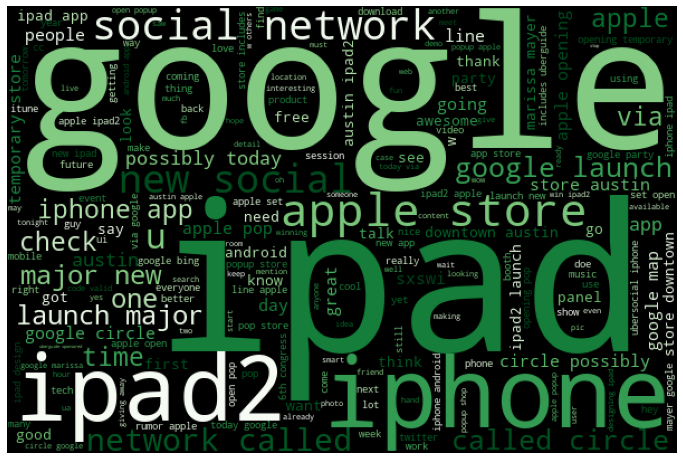

In [44]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped))

This is as expected, but largely dominated by brand names. Let's try it again without any of the brand words.

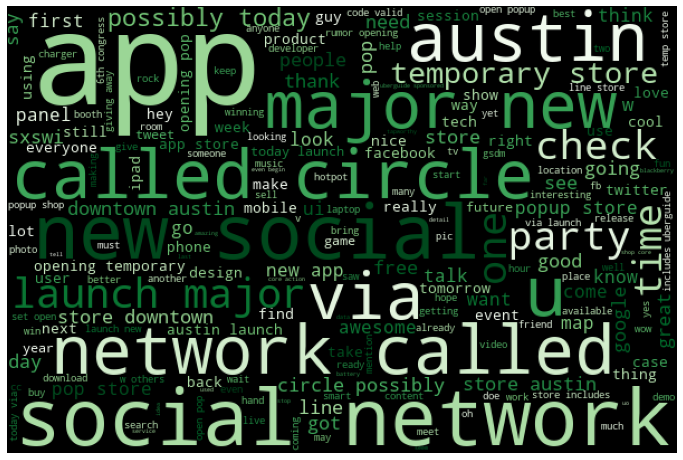

In [45]:
# word cloud of stopped words, omitting brand words
plot_wordcloud(make_wordcloud([word for word in tokens_stopped if word not in brand_words]))

This is not very illuminating just yet. We'll create some new word lists that focus just on the positives and negatives of each brand.

In [46]:
# a function that takes a list of tweets and 1) tokenizes them, 2) lemmatizes them, and 3) removes stopwords
def make_tokens(tweets):
    # make list of tokens
    tokens = tokenizer.tokenize(','.join(tweets))
    # lemmatize tokens
    tokens_lemmatized = [lemmatizer.lemmatize(word[1:]) for word in tokens if word.startswith('#')] + \
    [lemmatizer.lemmatize(word) for word in tokens if not word.startswith('#')]
    # stop tokens
    tokens_lemmatized = ipad_fix(tokens_lemmatized)
    tokens_stopped = [word for word in tokens_lemmatized if \
                      word not in stop_list and \
                      word not in brand_words]
    return tokens_stopped

In [47]:
# make tokens lists for all / positive / negative tweets, for both apple and google
tokens_apple_all = make_tokens(df[df.brand == 'apple'].text.to_list())
tokens_apple_pos = make_tokens(df[(df.brand == 'apple') & (df.sentiment == 'positive')].text.to_list())
tokens_apple_neg = make_tokens(df[(df.brand == 'apple') & (df.sentiment == 'negative')].text.to_list())
tokens_google_all = make_tokens(df[df.brand == 'google'].text.to_list())
tokens_google_pos = make_tokens(df[(df.brand == 'google') & (df.sentiment == 'positive')].text.to_list())
tokens_google_neg = make_tokens(df[(df.brand == 'google') & (df.sentiment == 'negative')].text.to_list())

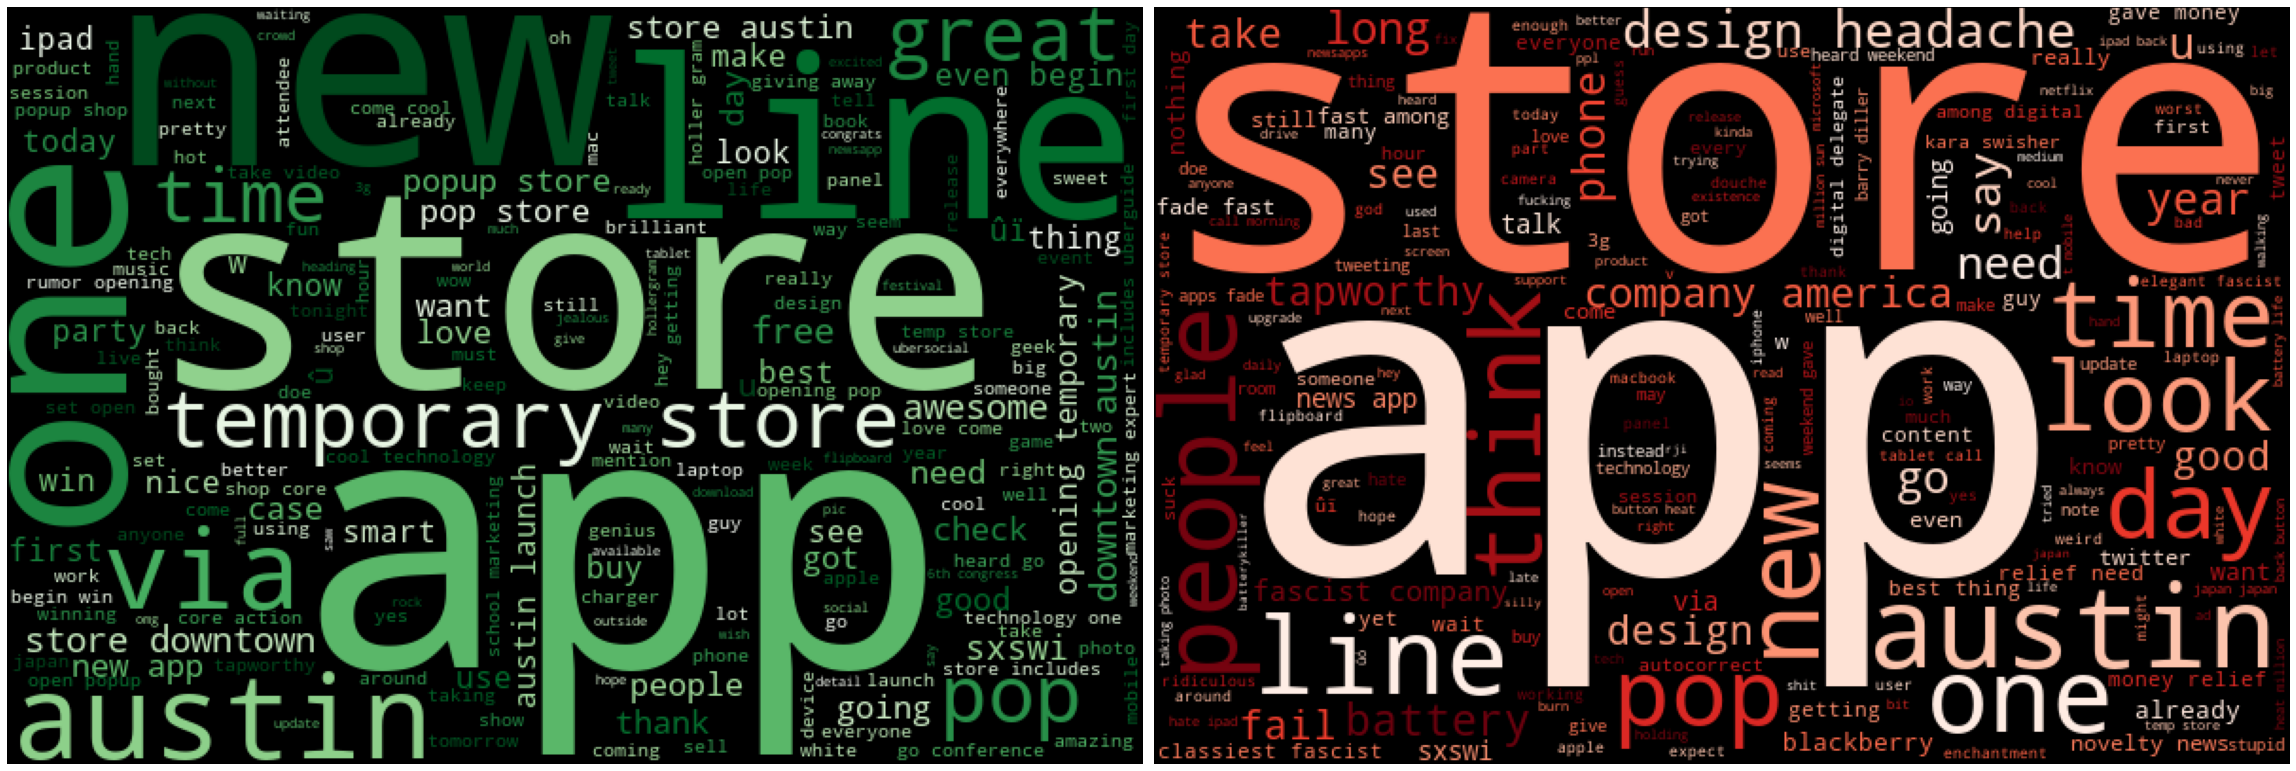

In [48]:
# show positive and negative wordclouds for apple side by side
fig, ax = plt.subplots(figsize=(32,24), ncols=2)
# plt.suptitle('Positive and Negative Word Clouds for Apple', fontsize=25)
ax[0].imshow(make_wordcloud(tokens_apple_pos))
ax[0].axis('off')
ax[1].imshow(make_wordcloud(tokens_apple_neg, colormap='Reds'))
ax[1].axis('off')
plt.tight_layout();

A lot of the positive buzz about Apple seems to be about the pop-up store in downtown Austin — terms like "temporary store", etc. There are even positive sentiments about the "line" there.

Some negative terms that stand out are "design headache" and "battery", as well as several phrases about a "fascist company" or an "elegant fascist". Also someone named "Kara Swisher" shows up.

Let's explore some context.

In [49]:
tweet_samples('temporary store')

rt @mention smart company. rt @mention it's not a rumor: apple opening up a temporary store in downtown austin for #sxsw &amp;ipad 2 launch bit.ly/g03mzb
#apple said to open temporary store at #sxsw {link} via @mention
ha! rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw &amp; the ipad 2 launch {link}
@mention @mention apple to open temporary store friday in the scarbrough building at 6th and congress #sxsw {link}
it's not a rumor: apple opening up a temporary store in downtown austin for #sxsw &amp;ipad 2 launch {link}


In [50]:
tweet_samples('line', count=10)

line is wrapping around the block for an ipad 2 again for a second day at #sxsw! {link}
ipad 2 update: online sales start at 12:01am pst | 3am est on 3/11/11 | 2-day free shipping |fyi: #sxsw - popup store downtown austin #apple
rt @mention the apple pop-up store line finally dwindled. time to check out ipad2. #sxsw
google seems to have sabotaged my youtube account - wtf? are they trying to own the entire online ecosystem?  very bad form #sxsw
the line for the ipad 2 at #sxsw.  {link}
apparently the line to get an ipad at the #sxsw store grew by 2 blocks to 5 blocks in the past 30 mins. wut.
the end of the line is one block away from the apple pop up #sxsw
who's gonna get an ipad2 today or this weekend? #ipad2 i bet the lines at the apple pop up store in austin for #sxsw will be huge.
#sxsw day 5 at the #apple store and there's still a line...and growing {link}
headline: &quot;#ipad 2 is the must-have gadget at #sxsw&quot; hmm... i could have seen that one coming! {link} #gadget


In [51]:
tweet_samples('design headache')

at #sxsw #tapworthy ipad design headaches - avoiding the pitfalls of the new design challenges
at #sxsw #tapworthy ipad design headaches - avoiding the pitfalls of the new design challenges
heading to ipad design headaches in hilton - salon j #sxsw
really excited for my first panel!  #tapworthy ipad design headaches  should be awesome.  the book is!  #sxsw #gsdm
rt @mention good morning, #sxsw. what r u talking abt on twitter now according to @mention @mention ipad design, geogames and design headaches


In [52]:
tweet_samples('battery')

#sxsw just helped @mention charge her iphone with my newtrent imp1000 battery pack. i love this thing! #unpaid #endorsement
ah! iphone battery fully recharged courtesy of @mention charge anywhere. find @mention or i at #sxsw &amp; charge up on the fly!
best schwag i've seen at #sxsw is the @mention battery charger for your iphone. how do i get one?!?!
ah! iphone battery fully recharged courtesy of @mention charge anywhere. find @mention or i at #sxsw &amp; charge up on the fly!
iphone battery maintenance is a fine art at #sxsw


In [53]:
tweet_samples('kara swisher')

rt @mention &quot;apple: the most elegant fascist corporation in america today.&quot; -- kara swisher #sxsw #flipboard
apple is the classiest facist company in america. - kara swisher #sxsw
apple...&quot;the classiest fascist company in america&quot; kara swisher #sxsw
&quot;apple: the most elegant fascist corporation in america today.&quot; -- kara swisher #sxsw #flipboard
apple...&quot;the classiest fascist company in america&quot; kara swisher #sxsw


### Summary of Apple's word clouds

A lot of people are talking about Apple's temporary pop-up store and reporting on the experience of waiting in line, not necessarily complaining about it.

Evidently Kara Swisher is a person who made a snarky comment about Apple being fascist.

It looks like some media was using the phrase "design headache" in reference to the (new or old?) iPad, but the phrase was used beyond just the tweets that linked to certain articles.

Some people mentioned their iPhone batteries dying. This appears to be a common problem.

Let's do the same for Google.

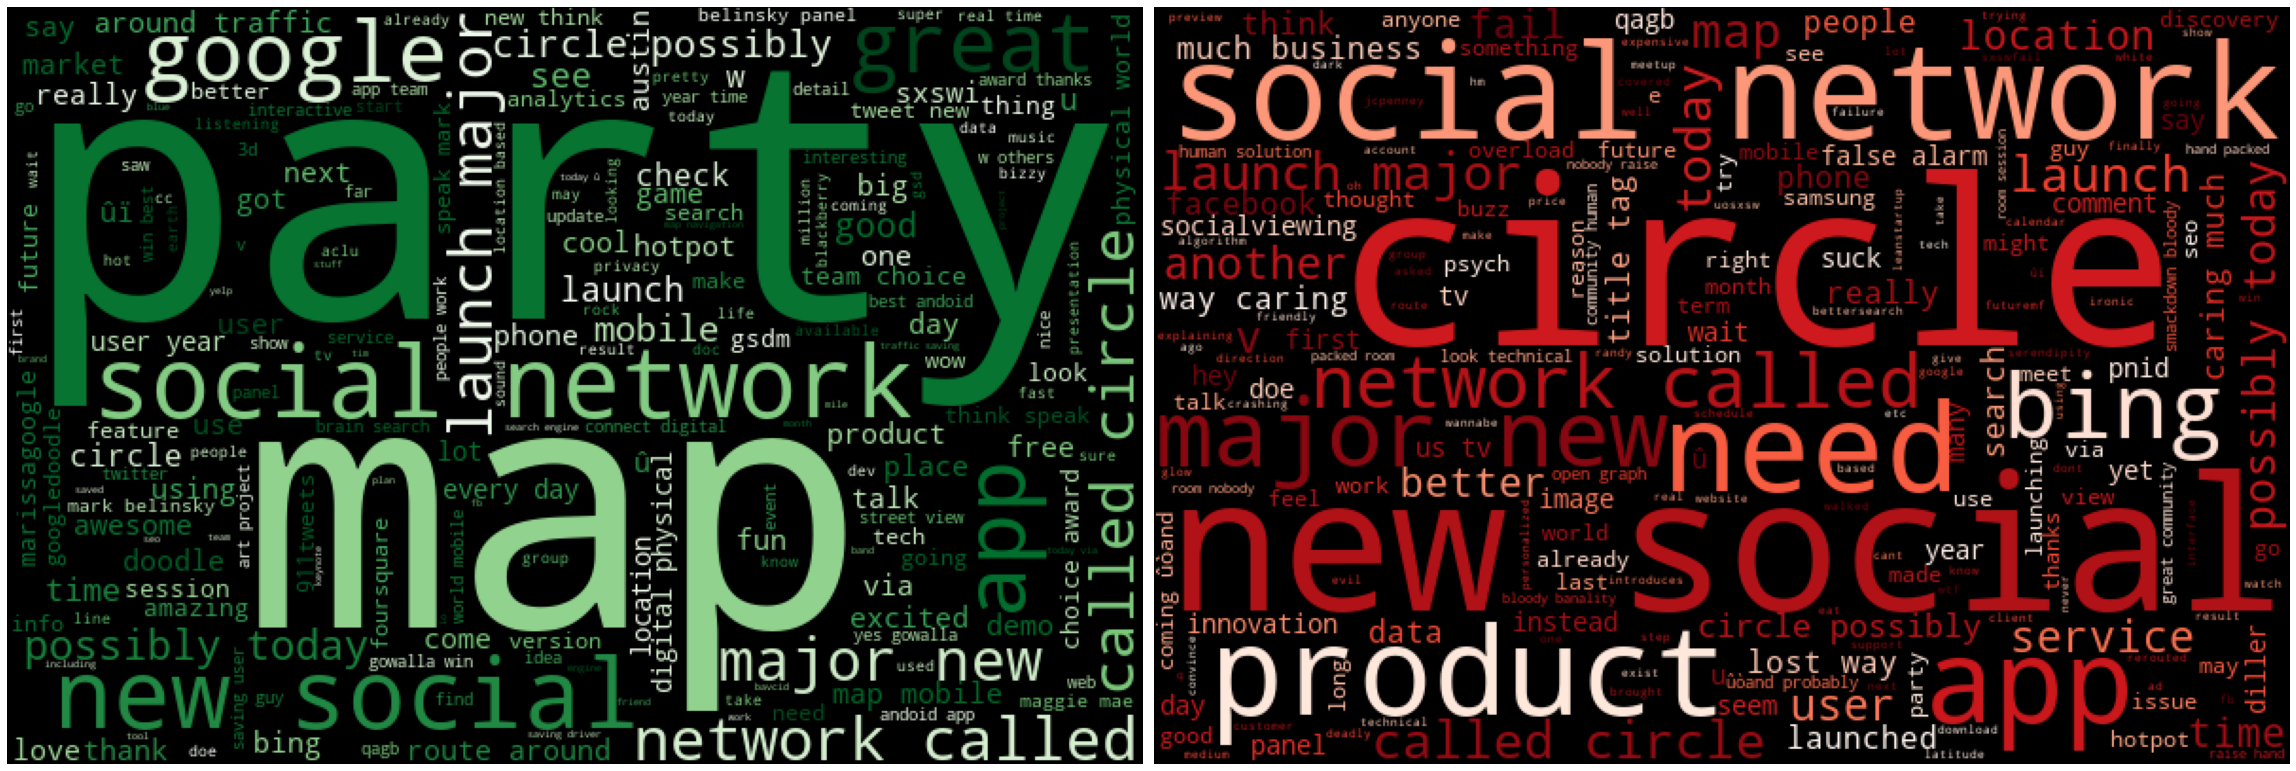

In [54]:
# show positive and negative wordclouds for google side by side
fig, ax = plt.subplots(figsize=(32,24), ncols=2)
ax[0].imshow(make_wordcloud(tokens_google_pos))
ax[0].axis('off')
ax[1].imshow(make_wordcloud(tokens_google_neg, colormap='Reds'))
ax[1].axis('off')
plt.tight_layout();

In [55]:
tweet_samples('party', count=10)

google party @mention maggie maes rocks like it's 1986. #sxsw
rt @mention {link} samsung galaxy s ii appears at fcc and team android #sxsw party {link} #android #followback
rt @mention ûïline moving fast! rt @mention have seen two impressive lines since i'm at #sxsw  the one at the apple store &amp; @mention party now
among the things i am missing at #sxsw: the google-aclu 80's dance party.
free iphone chargers at austin music hall / ignite party #sxsw
android party ... #sxsw (@mention lustre pearl bar w/ 63 others) {link}
#sxsw google party in austin texas, on entry received anti privacy law petition, sunglasses and free beer. {link}
google's 1986 themed party at #sxsw  @mention maggie mae's {link}
damn you @mention party, for walking me past the apple store last night. #sxsw
queueing for ipads instead of partying. honestly, geeks, get a grip! rt @mention the ipad 2 takes over #sxsw [video] - {link}


In [56]:
tweet_samples('maps')

#google shows super-fast google maps for mobile with 3d rendering. #sxsw
i believe it - i almost always use google maps on my iphone rt @mention 40% of google maps use is mobile says @mention #sxsw
latest google maps mobile app demo #sxsw lots of stats. drink the coolaid.
marissa mayer talks the future of google maps and discusses hotpot, its answer to location-based ratings and recommendations #sxsw -kek
google hotpot demo at #sxsw seems a whole lot like #yelp to me- innovate or not be left outa game? they show heat maps2 {link}


In [57]:
tweet_samples('circles', count=10)

rt @mention interesting --&gt;&gt; rt @mention google to launch major new social network called circles, possibly today {link} #sxsw
you finally get everyone to buy in to facebook and then google introduces circles. no fair. stop with all the innovation, people #sxsw
google launching secret new social network called &quot;circles&quot; {link} #sxsw
rt @mention google to launch major new social network called circles, possibly today #sxsw {link}
rt @mention will google reveal a new social network called circles? #google #facebook #twitter #sxsw {link} via @mention
google to launch major new social network called circles, possibly today rww.to/f6bcet #sxsw
rt@mention google to launch major new social network called circles, possibly today {link} #sxsw #twnp #socmedia
this #google circles has everyone going around in circles! {link} #sxsw
rt @mention the big #sxsw rumor: google to launch ludicon based &quot;circles&quot; facebook killer. supposedly @mention already saw it and it's ossum.


In [58]:
tweet_samples('new social')

#circles set to fail for being too complicated by june. rt @mention google set to launch new social network #circles today at #sxsw
rt @mention google to launch major new social network called circles, possibly today {link} #sxsw

buzz 2.0?  lol
rt @mention google to launch major new social network called circles, {link} #sxsw - brazil's orkut users have been waiting.
google to launch major new social network called circles, possibly today (updated) at #sxsw {link}
ûï@mention google to launch major new social network called circles, possibly today {link} #sxswû te dije wey @mention


In [59]:
tweet_samples('bing')

the ppl have spoken &quot;great #sxsw session w/ bing, google and danny sullivan. bring it back next year with a larger room!&quot;: #qagb #sxswi
in line for the google and bing pagerank session. hope there's a smack down! #sxsw (@mention hilton, salon j w/ 44 others) {link}
#qagb #sxswi rt @mention despite drawing giant crowd, google-bing q&amp;a discussion is very inside baseball. #sxsw
rt @mention rt @mention q&amp;a with google's @mention &amp; bing's @mention on ranking - my #sxsw session this mon 12:30pm {link}
i've been looking forward to the google/bing q/a on website ranking all week. #sxsw


### Summary of Google's word clouds

It's clear that Google's attempt at a new social network called Circles was not successful.

However, there was a lot of genuinely positive sentiment about Google Maps and its potential.

The term "party" applied to a number of contexts, but prominent among them was the party that Google hosted, which seemed to be quite popular.

# Modeling

Here we will classify only tweets that have positive or non-positive sentiments.

In [60]:
df_posnon = df.copy()
# convert sentiment to 0s and 1s
# both 'negative' and 'neutral' will have zero values
df_posnon.sentiment = df_posnon.sentiment.apply(lambda x: 1 if x == 'positive' else 0)

In [61]:
df_posnon.sentiment.value_counts()

sentiment
0    6102
1    2969
Name: count, dtype: int64

## Tokenizer

We'll use what we developed during exploration to make a custom tokenizer function. This will perform all of the following:
- tokenize tweets
- remove accents and hashtags
- lemmatize tokens
- join "ipad" and "2" where appropriate

This tokenizer will *not* remove stopwords, as we may wish to vary our choice of stopwords in the models.

In [62]:
# make tokenizer
def custom_tokenize(document):
    # instantiate tokenizer
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True
    )

    # create list of tokens from data set
    tokens = tokenizer.tokenize(document)

    # remove hashtags and accents
    tokens = [unidecode(word) for word in tokens if not word.startswith('#')] + \
    [unidecode(word[1:]) for word in tokens if word.startswith('#')]
    
    # remove stop words
    tokens = [word for word in tokens if not word in stop_list]

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize the list of words
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    # perform ipad fix
    tokens_lemmatized = ipad_fix(tokens_lemmatized)
    
    return tokens_lemmatized

## Train and test sets

We'll split the data into train and test sets.

In [63]:
# split the data into target (sentiment) and predictor (text)
X, y = df_posnon['text'], df_posnon['sentiment']

# split the data into train and test sets
# set random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Metric choice = accuracy

As we've chosen to develop a binary classifier, and our classes aren't wildly out of balance (roughly a 2:1 ratio), we will be satisfied with a model that merely achieves accuracy, which is the measure of the percentage of tweets that it correctly identifies as positive or non-positive.

If we were developing a multi-class classifier, or if we were focusing on just positive versus negative, then there would be a significant class imbalance in either case. With a more significant class imbalance, it becomes easier (and less impressive) to achieve high accuracy. For example, if 90% of the tweets are positive, then models would be encouraged to label most tweets positive and not suffer much cost by mislabeling the negative ones. In this case, it would be wise to look more closely at precision or recall in order to get a more sophisticated model.

## Plurality check

It will be instructive to recall the percentage of the plurality in the target feature (sentiment). Models should be evaluated in relation to this.

In [64]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

sentiment
0    0.6736
1    0.3264
Name: proportion, dtype: float64

In [65]:
y_pred_train = y_train.copy().apply(lambda x: 0)
train_acc = round(accuracy_score(y_pred_train, y_train),4)
y_pred_test = y_test.copy().apply(lambda x: 0)
test_acc = round(accuracy_score(y_pred_test, y_test),4)
print(
    'Plurality Calculation',
    '\n\nTraining Score: '+str(train_acc),
    '\nTest Score:     '+str(test_acc)
)

Plurality Calculation 

Training Score: 0.6736 
Test Score:     0.6689


## Results function

We'll create a function that takes the pipeline we've created and displays only the results we're interested in.

In [66]:
def model_results(pipeline):
    # fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # plot the normalized confusion matrix
    plot_confusion_matrix(estimator=pipeline, X=X_test, y_true=y_test, cmap='Greens', 
                          normalize='true', 
                          display_labels=['Non-positive', 'Positive'])

## Naive Bayes (BASELINE MODEL)
### Rough model

Naive Bayes
Training Score: 0.7937     
Test Score:     0.7152


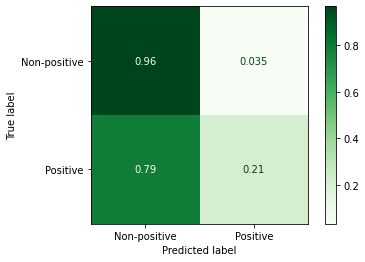

In [67]:
# Multinomial Naive Bayes

# create pipeline
pipeline_nb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', MultinomialNB())
])
print('Naive Bayes')
# create model from pipeline and display results
model_results(pipeline_nb)

In [68]:
if do_grids == True:

    param_grid = {'clf__alpha': [0.001, 0.01, 0.1, 1]}
    gridsearch = GridSearchCV(pipeline_nb, param_grid=param_grid, 
                                  scoring='accuracy')

    gridsearch.fit(X_train, y_train)
    gridsearch.best_params_

### Tuned Naive Bayes

Naive Bayes
Training Score: 0.8899     
Test Score:     0.7218


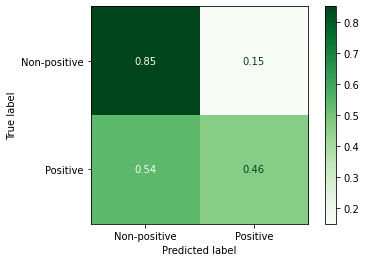

In [69]:
# Tuned Multinomial Naive Bayes

# create pipeline
pipeline_nb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', MultinomialNB(alpha=0.1))
])
print('Naive Bayes')
# create model from pipeline and display results
model_results(pipeline_nb)

### Naive Bayes with oversampling

Naive Bayes with oversampling
Training Score: 0.8665     
Test Score:     0.6799


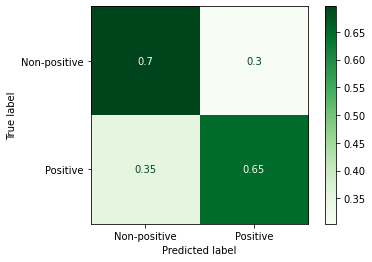

In [70]:
# Multinomial Naive Bayes with oversampling

# create pipeline
pipeline_nb_os = imblearn.pipeline.Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set oversampler
    ('os', RandomOverSampler(random_state=SEED)),
    # set classifier
    ('clf', MultinomialNB(alpha=0.1))
])
print('Naive Bayes with oversampling')
# create model from pipeline and display results
model_results(pipeline_nb_os)

## Logistic Regression
### rough model

Logistic Regression
Training Score: 0.9593     
Test Score:     0.6259


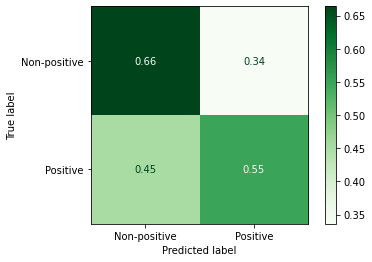

In [71]:
# logistic regression

# create pipeline
pipeline_lr = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=SEED))
])
print('Logistic Regression')
# create model from pipeline and display results
model_results(pipeline_lr)

## Logistic Regression with oversampling

Logistic Regression
Training Score: 0.9577     
Test Score:     0.6165


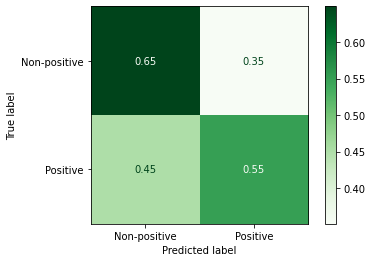

In [72]:
# logistic regression with oversampling

# create pipeline
pipeline_lr_os = imblearn.pipeline.Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set oversampler
    ('os', RandomOverSampler(random_state=SEED)),
    # set classifier
    ('clf', LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=SEED))
])
print('Logistic Regression')
# create model from pipeline and display results
model_results(pipeline_lr_os)

## Decision Tree
### Rough model

Decision Tree
Training Score: 0.9653     
Test Score:     0.7047


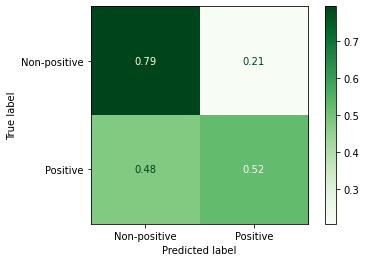

In [73]:
# decision tree

# create pipeline
pipeline_dt = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', DecisionTreeClassifier(random_state=SEED))
])
print('Decision Tree')
# create model from pipeline and display results
model_results(pipeline_dt)

In [74]:
if do_grids == True:

    param_grid = {'clf__criterion': ['gini', 'entropy'], 
            'clf__max_depth': [10, 20, None],
            'clf__min_samples_leaf': [1, 2, 3]
           }

    gridsearch = GridSearchCV(estimator=pipeline_dt, param_grid = param_grid, scoring='accuracy')

    gridsearch.fit(X_train,  y_train)
    gridsearch.best_params_

### Tuned Decision Tree

Decision Tree
Training Score: 0.7926     
Test Score:     0.7157


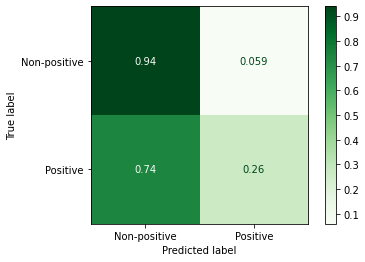

In [75]:
# tuned decision tree

# create pipeline
pipeline_dt = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', DecisionTreeClassifier(
        criterion='gini',
        max_depth=20,
        min_samples_leaf=1,
        random_state=SEED))
])
print('Decision Tree')
# create model from pipeline and display results
model_results(pipeline_dt)

## Bagged Trees

Bagged Trees
Training Score: 0.7472     
Test Score:     0.7174


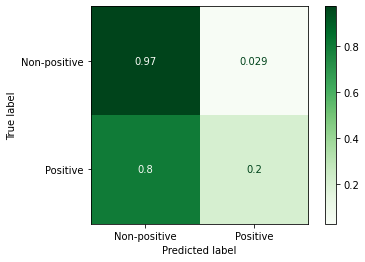

In [76]:
# bagged trees

# create pipeline
pipeline_bag = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', max_depth=10), n_estimators=20, random_state=SEED))
])
print('Bagged Trees')
# create model from pipeline and display results
model_results(pipeline_bag)

## Random Forest
### Rough model

Random Forest
Training Score: 0.9653     
Test Score:     0.7317


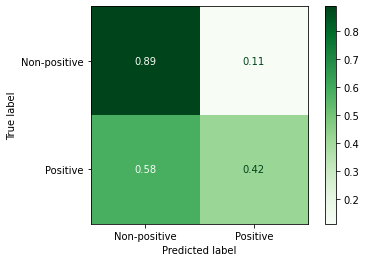

In [77]:
# random forest

# create pipeline
pipeline_rf = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', RandomForestClassifier(random_state=SEED))
])
print('Random Forest')
# create model from pipeline and display results
model_results(pipeline_rf)

In [78]:
if do_grids == True:

    param_grid = {'clf__criterion': ['gini', 'entropy'], 
            'clf__max_depth': [10, 20, None],
            'clf__min_samples_leaf': [1, 2, 3]
           }

    gridsearch = GridSearchCV(estimator=pipeline_rf, param_grid = param_grid, scoring='accuracy')

    gridsearch.fit(X_train,  y_train)
    gridsearch.best_params_

### Tuned Random Forest

Random Forest
Training Score: 0.864     
Test Score:     0.7245


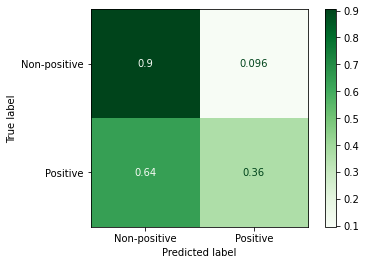

In [79]:
# tuned random forest

# create pipeline
pipeline_rf = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', RandomForestClassifier(criterion='entropy',
                                   max_depth=None,
                                   min_samples_leaf=2,
                                   random_state=SEED))
])
print('Random Forest')
# create model from pipeline and display results
model_results(pipeline_rf)

## Support Vector Machine

Support Vector Machine
Training Score: 0.926     
Test Score:     0.7433


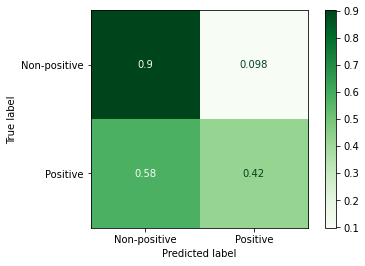

In [80]:
# support vector machine

# create pipeline
pipeline_svm = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', SVC(random_state=SEED))
])
print('Support Vector Machine')
# create model from pipeline and display results
model_results(pipeline_svm)

## AdaBoost

AdaBoost
Training Score: 0.7408     
Test Score:     0.7063


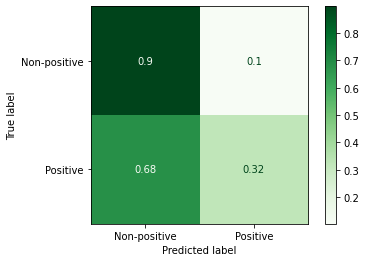

In [81]:
# adaboost

# create pipeline
pipeline_ab = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', AdaBoostClassifier(random_state=SEED))
])
print('AdaBoost')
# create model from pipeline and display results
model_results(pipeline_ab)

## Gradient Boost

Gradient Boost
Training Score: 0.7494     
Test Score:     0.7229


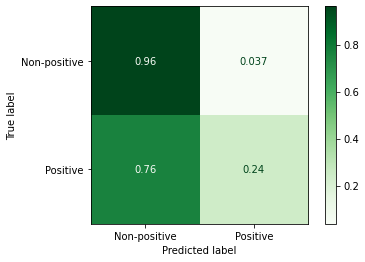

In [82]:
# gradient boost

# create pipeline
pipeline_gb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', GradientBoostingClassifier(random_state=SEED))
])
print('Gradient Boost')
# create model from pipeline and display results
model_results(pipeline_gb)

## XGBoost

Gradient Boost
Training Score: 0.8408     
Test Score:     0.7328


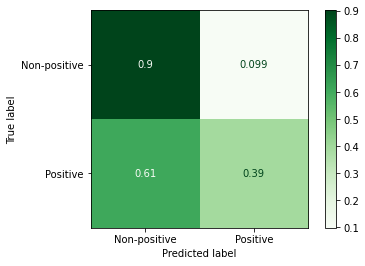

In [83]:
# XGB

# create pipeline
pipeline_xgb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', XGBClassifier(random_state=SEED))
])
print('Gradient Boost')
# create model from pipeline and display results
model_results(pipeline_xgb)

# Evaluation

We attempted to oversample the data in order to deal with the class imbalance issue. This only gave worse results each time we tried it.

None of our efforts at tuning the models made a positive impact either.

Most of the models seem to overfit the training data, as evidenced by the large gap between training accuracy and test accuracy. The only models where the two accuracy scores seemed reasonably close were Bagged Trees, AdaBoost, and Gradient Boost. Of these models, Gradient Boost gave the best test accuracy, so we chose Gradient Boost as our final model.

# Recommendations

1. Evidence suggests the pop-up store was very popular. This was an effective way to get people excited about the product at a time when they could share their excitement with others around them. This event should be repeated if possible.


2. Apple should consider addressing battery life and design issues with some of their products. These topics didn't fully dominate the discussion by any means, but they were the most significant of Apple's negative topics of any substance.


3. The party Google hosted was clearly very popular and appeared to drive a lot of what buzz they enjoyed at the festival. Apple should consider hosting parties at festivals in a similar manner.

# Further Inquiry

More sophisticated modeling techniques might be able to better analyze either a direct positive v. negative comparison or even a multi-class analysis (positive, negative, and neutral). The class imbalances make this difficult.

More direct analysis could be done with the tweets that mentioned *both* Apple and Google brands. Perhaps these tweets feature direct comparisons that could be very illuminating.

With more time we would have liked to explore feature importances of the various models.

We would also like to have explored *why* the models were overfitting the training data so consistently and what aspects could have been changed to prevent this.

We would have liked to investigate other features, such as tweet length (counting both characters and words), to see if that added anything to the models.